<a href="https://colab.research.google.com/github/minofeel/-/blob/main/pmlb%2C_tiny_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
pip install pmlb scikit-learn gplearn pandas numpy matplotlib seaborn

In [13]:
import numpy as np
import pandas as pd
from pmlb import regression_dataset_names, fetch_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 각 모델별로 필요한 라이브러리
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from gplearn.genetic import SymbolicRegressor
import math
import random
from random import randint
from statistics import mean
from copy import deepcopy

In [14]:
# tiny_GP 관련 설정 및 클래스 정의
POP_SIZE        = 50
MIN_DEPTH       = 2
MAX_DEPTH       = 4
GENERATIONS     = 20
TOURNAMENT_SIZE = 3
XO_RATE         = 0.8
PROB_MUTATION   = 0.1

In [15]:
# 함수 집합 정의
def add(x, y): return x + y
def sub(x, y): return x - y
def mul(x, y): return x * y
def protected_div(x, y): return x / y if y != 0 else x
def sin(x): return math.sin(x)
def cos(x): return math.cos(x)
def protected_sqrt(x): return math.sqrt(abs(x))
def protected_log(x): return math.log(abs(x)) if x != 0 else 0

FUNCTIONS = [add, sub, mul, protected_div, sin, cos, protected_sqrt, protected_log]

class GPTree:
    def __init__(self, data = None, left = None, right = None):
        self.data  = data
        self.left  = left
        self.right = right

    def node_label(self): # 노드의 라벨 반환
        if (self.data in FUNCTIONS):
            return self.data.__name__
        else:
            return str(self.data)

    def print_tree(self, prefix = ""): # 트리 출력
        print("%s%s" % (prefix, self.node_label()))
        if self.left:  self.left.print_tree (prefix + "   ")
        if self.right: self.right.print_tree(prefix + "   ")

    def compute_tree(self, variables):
        if (self.data in FUNCTIONS):
            return self.data(self.left.compute_tree(variables), self.right.compute_tree(variables))
        elif self.data in variables:
            return variables[self.data]
        else:
            return self.data

    def random_tree(self, grow, max_depth, depth = 0): # 랜덤 트리 생성
        if depth < MIN_DEPTH or (depth < max_depth and not grow):
            self.data = FUNCTIONS[randint(0, len(FUNCTIONS)-1)]
        elif depth >= max_depth:
            self.data = self.terminals[randint(0, len(self.terminals)-1)]
        else: # 중간 깊이, grow
            if random.random() > 0.5:
                self.data = self.terminals[randint(0, len(self.terminals)-1)]
            else:
                self.data = FUNCTIONS[randint(0, len(FUNCTIONS)-1)]
        if self.data in FUNCTIONS:
            self.left = GPTree()
            self.left.terminals = self.terminals
            self.left.random_tree(grow, max_depth, depth = depth + 1)
            self.right = GPTree()
            self.right.terminals = self.terminals
            self.right.random_tree(grow, max_depth, depth = depth + 1)

    def mutation(self):
        if random.random() < PROB_MUTATION: # 현재 노드에서 돌연변이 발생
            self.random_tree(grow = True, max_depth = 2)
        else:
            if self.left: self.left.mutation()
            if self.right: self.right.mutation()

    def size(self): # 트리의 노드 수
        if self.data in self.terminals: return 1
        l = self.left.size()  if self.left  else 0
        r = self.right.size() if self.right else 0
        return 1 + l + r

    def build_subtree(self): # 서브트리 생성
        t = GPTree()
        t.data = self.data
        if self.left:
            t.left  = self.left.build_subtree()
            t.left.terminals = self.terminals
        if self.right:
            t.right = self.right.build_subtree()
            t.right.terminals = self.terminals
        return t

    def scan_tree(self, count, second): # 트리 탐색
        count[0] -= 1
        if count[0] <= 1:
            if not second: # 현재 노드에서 서브트리 반환
                return self.build_subtree()
            else: # 서브트리를 현재 노드에 삽입
                self.data  = second.data
                self.left  = second.left
                self.right = second.right
        else:
            ret = None
            if self.left  and count[0] > 1: ret = self.left.scan_tree(count, second)
            if self.right and count[0] > 1: ret = self.right.scan_tree(count, second)
            return ret

    def crossover(self, other): # 교차 연산
        if random.random() < XO_RATE:
            second = other.scan_tree([randint(1, other.size())], None) # 두 번째 트리에서 서브트리 선택
            self.scan_tree([randint(1, self.size())], second) # 첫 번째 트리에 서브트리 삽입

def init_population(terminals): # 초기 인구 생성
    pop = []
    for md in range(MIN_DEPTH, MAX_DEPTH + 1):
        for i in range(int(POP_SIZE/((MAX_DEPTH - MIN_DEPTH + 1)*2))):
            t = GPTree()
            t.terminals = terminals
            t.random_tree(grow = True, max_depth = md) # grow 방식
            pop.append(t)
            t = GPTree()
            t.terminals = terminals
            t.random_tree(grow = False, max_depth = md) # full 방식
            pop.append(t)
    return pop

def fitness(individual, dataset): # 적합도 함수 (평균 절대 오차의 역수)
    errors = []
    for data in dataset:
        try:
            pred = individual.compute_tree(data[0])
            if np.isfinite(pred):
                errors.append(abs(pred - data[1]))
            else:
                errors.append(float('inf'))
        except Exception:
            errors.append(float('inf'))
    mean_error = mean(errors)
    if np.isfinite(mean_error):
        return 1 / (1 + mean_error)
    else:
        return 0

def selection(population, fitnesses): # 토너먼트 선택
    tournament = [randint(0, len(population)-1) for i in range(TOURNAMENT_SIZE)]
    tournament_fitnesses = [fitnesses[i] for i in tournament]
    return deepcopy(population[tournament[tournament_fitnesses.index(max(tournament_fitnesses))]])

In [16]:
def run_tiny_gp(X_train, y_train, X_test, y_test, dataset_name):
    # 데이터 전처리
    # 변수 이름을 문자열로 변환
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    X_train.columns = [f'X{i}' for i in range(X_train.shape[1])]
    X_test.columns = X_train.columns
    terminals = list(X_train.columns) + [-2, -1, 0, 1, 2]

    # 데이터셋을 리스트 형태로 변환
    train_set = []
    for i in range(len(X_train)):
        variables = X_train.iloc[i].to_dict()
        target = y_train.iloc[i] if isinstance(y_train, pd.Series) else y_train[i]
        train_set.append([variables, target])

    test_set = []
    for i in range(len(X_test)):
        variables = X_test.iloc[i].to_dict()
        target = y_test.iloc[i] if isinstance(y_test, pd.Series) else y_test[i]
        test_set.append([variables, target])

    # 난수 초기화
    random.seed()

    # 초기 인구 생성
    population= init_population(terminals)
    best_of_run = None
    best_of_run_f = 0
    fitnesses = [fitness(individual, train_set) for individual in population]

    # 진화 시작
    for gen in range(GENERATIONS):
        nextgen_population=[]
        for i in range(POP_SIZE):
            parent1 = selection(population, fitnesses)
            parent2 = selection(population, fitnesses)
            parent1.crossover(parent2)
            parent1.mutation()
            nextgen_population.append(parent1)
        population = nextgen_population
        fitnesses = [fitness(individual, train_set) for individual in population]
        gen_best_fitness = max(fitnesses)
        if gen_best_fitness > best_of_run_f:
            best_of_run_f = gen_best_fitness
            best_of_run = deepcopy(population[fitnesses.index(gen_best_fitness)])
        if best_of_run_f == 1:
            break

    # 테스트 세트에서 평가
    gp_pred = []
    y_test_gp = []
    for data in test_set:
        try:
            pred = best_of_run.compute_tree(data[0])
            if np.isfinite(pred):
                gp_pred.append(pred)
                y_test_gp.append(data[1])
        except Exception:
            pass  # 오류 발생 시 해당 데이터는 건너뜁니다.

    # 성능 지표 계산
    if len(gp_pred) > 0:
        mae_value = mean_absolute_error(y_test_gp, gp_pred)
        mse_value = mean_squared_error(y_test_gp, gp_pred)
        rmse_value = mean_squared_error(y_test_gp, gp_pred, squared=False)
        r2_value = r2_score(y_test_gp, gp_pred)
    else:
        mae_value = mse_value = rmse_value = r2_value = float('inf')

    # 최적 수식 추출
    import io
    import sys

    # 트리를 문자열로 저장
    old_stdout = sys.stdout
    new_stdout = io.StringIO()
    sys.stdout = new_stdout
    best_of_run.print_tree()
    expression = new_stdout.getvalue()
    sys.stdout = old_stdout

    return {
        'MAE': mae_value,
        'MSE': mse_value,
        'RMSE': rmse_value,
        'R2': r2_value,
        'Expression': expression
    }

In [17]:
def run_linear_regression(X_train, y_train, X_test, y_test):
    # 모델 학습
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # 예측 및 성능 평가
    y_pred = lr.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Coefficients': lr.coef_.tolist(),
        'Intercept': lr.intercept_
    }

In [18]:
def run_decision_tree(X_train, y_train, X_test, y_test):
    # 모델 학습
    dt = DecisionTreeRegressor(random_state=42)
    dt.fit(X_train, y_train)

    # 예측 및 성능 평가
    y_pred = dt.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'TreeDepth': dt.get_depth(),
        'NumLeaves': dt.get_n_leaves()
    }

In [19]:
def run_random_forest(X_train, y_train, X_test, y_test):
    # 모델 학습
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)

    # 예측 및 성능 평가
    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'NumTrees': len(rf.estimators_)
    }

In [20]:
def run_symbolic_regression(X_train, y_train, X_test, y_test):
    # 심볼릭 회귀 모델 생성
    function_set = ['add', 'sub', 'mul', 'div', 'sin', 'cos', 'sqrt', 'log']
    est_gp = SymbolicRegressor(
        population_size=500,
        generations=10,
        stopping_criteria=0.01,
        p_crossover=0.7,
        p_subtree_mutation=0.1,
        p_hoist_mutation=0.05,
        p_point_mutation=0.1,
        max_samples=0.9,
        verbose=0,
        parsimony_coefficient=0.01,
        random_state=42,
        function_set=function_set
    )

    # 모델 학습
    est_gp.fit(X_train, y_train)

    # 예측 및 성능 평가
    y_pred = est_gp.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    # 모델 수식 추출
    expression = str(est_gp._program)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Expression': expression
    }

In [10]:
# 회귀 데이터셋 목록
dataset_names = regression_dataset_names

# 결과를 저장할 리스트 초기화
results = []

for dataset_name in dataset_names:
    try:
        print(f"데이터셋 '{dataset_name}' 처리 중...")
        # 데이터셋 로드
        data = fetch_data(dataset_name, return_X_y=False)
        X = data.drop('target', axis=1)
        y = data['target']

        # 데이터셋 분할
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 모델 실행 및 성능 평가
        tiny_gp_metrics = run_tiny_gp(X_train, y_train, X_test, y_test, dataset_name)
        lr_metrics = run_linear_regression(X_train, y_train, X_test, y_test)
        dt_metrics = run_decision_tree(X_train, y_train, X_test, y_test)
        rf_metrics = run_random_forest(X_train, y_train, X_test, y_test)
        sr_metrics = run_symbolic_regression(X_train, y_train, X_test, y_test)

        # 결과 저장
        results.append({
            'Dataset': dataset_name,
            'tiny_GP': tiny_gp_metrics,
            'LinearRegression': lr_metrics,
            'DecisionTree': dt_metrics,
            'RandomForest': rf_metrics,
            'SymbolicRegression': sr_metrics
        })

        print(f"데이터셋 '{dataset_name}'에 대한 모델 평가 완료.")
    except Exception as e:
        print(f"데이터셋 '{dataset_name}' 처리 중 오류 발생: {e}")

데이터셋 '1027_ESL' 처리 중...
데이터셋 '1027_ESL'에 대한 모델 평가 완료.
데이터셋 '1028_SWD' 처리 중...
데이터셋 '1028_SWD'에 대한 모델 평가 완료.
데이터셋 '1029_LEV' 처리 중...
데이터셋 '1029_LEV'에 대한 모델 평가 완료.
데이터셋 '1030_ERA' 처리 중...
데이터셋 '1030_ERA'에 대한 모델 평가 완료.
데이터셋 '1089_USCrime' 처리 중...
데이터셋 '1089_USCrime'에 대한 모델 평가 완료.
데이터셋 '1096_FacultySalaries' 처리 중...
데이터셋 '1096_FacultySalaries'에 대한 모델 평가 완료.
데이터셋 '1191_BNG_pbc' 처리 중...
데이터셋 '1191_BNG_pbc'에 대한 모델 평가 완료.
데이터셋 '1193_BNG_lowbwt' 처리 중...
데이터셋 '1193_BNG_lowbwt'에 대한 모델 평가 완료.
데이터셋 '1196_BNG_pharynx' 처리 중...
데이터셋 '1196_BNG_pharynx'에 대한 모델 평가 완료.
데이터셋 '1199_BNG_echoMonths' 처리 중...
데이터셋 '1199_BNG_echoMonths'에 대한 모델 평가 완료.
데이터셋 '1201_BNG_breastTumor' 처리 중...
데이터셋 '1201_BNG_breastTumor'에 대한 모델 평가 완료.
데이터셋 '1203_BNG_pwLinear' 처리 중...
데이터셋 '1203_BNG_pwLinear'에 대한 모델 평가 완료.
데이터셋 '1595_poker' 처리 중...
데이터셋 '1595_poker'에 대한 모델 평가 완료.
데이터셋 '192_vineyard' 처리 중...
데이터셋 '192_vineyard'에 대한 모델 평가 완료.
데이터셋 '195_auto_price' 처리 중...
데이터셋 '195_auto_price'에 대한 모델 평가 완료.
데이터셋 '197_cpu_act' 처리 중...
데이터셋 

In [11]:
# 결과를 pandas DataFrame으로 변환
results_df = pd.DataFrame(results)

# 결과를 CSV 파일로 저장
results_df.to_csv('model_comparison_results.csv', index=False)

In [35]:
import pandas as pd

# 가정: `results`는 이전 단계에서 얻은 모든 데이터셋에 대한 모델별 평가 결과를 포함하고 있음
# 예시: 사용자 코드에서 생성된 results 구조를 이용하여 표 생성

# 데이터 프레임 생성을 위한 리스트 준비
data_entries = []
columns = ['Dataset', 'Model', 'MAE', 'MSE', 'RMSE', 'R2']

# 데이터를 재구성
for result in results:
    dataset_name = result['Dataset']
    for model_name, metrics in result.items():
        if model_name != 'Dataset':  # 모델 데이터만 처리
            entry = {
                'Dataset': dataset_name,
                'Model': model_name,
                **metrics
            }
            data_entries.append(entry)

# DataFrame 생성
df = pd.DataFrame(data_entries, columns=columns)

# 데이터 프레임 표시
df

,Dataset,Model,MAE,MSE,RMSE,R2
0,1027_ESL,tiny_GP,0.540816,0.663265,0.814411,0.578062
1,1027_ESL,LinearRegression,0.415622,0.277673,0.526947,0.823357
2,1027_ESL,DecisionTree,0.420756,0.501189,0.707947,0.681167
3,1027_ESL,RandomForest,0.415426,0.405870,0.637080,0.741804
4,1027_ESL,SymbolicRegression,0.540816,0.663265,0.814411,0.578062
...,...,...,...,...,...,...
605,titanic,tiny_GP,0.704762,0.704762,0.839501,-2.387097
606,titanic,LinearRegression,0.323154,0.163096,0.403852,0.216156
607,titanic,DecisionTree,0.276885,0.233934,0.483667,-0.124289
608,titanic,RandomForest,0.275158,0.165670,0.407026,0.203787


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['MSE'].plot(kind='hist', bins=20, title='MSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='MAE', y='MSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='MSE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='RMSE', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['MAE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('MAE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['MSE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('MSE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['RMSE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('RMSE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['MSE'].plot(kind='line', figsize=(8, 4), title='MSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='Model', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='MAE', y='Model', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='MSE', y='Model', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='RMSE', y='Model', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

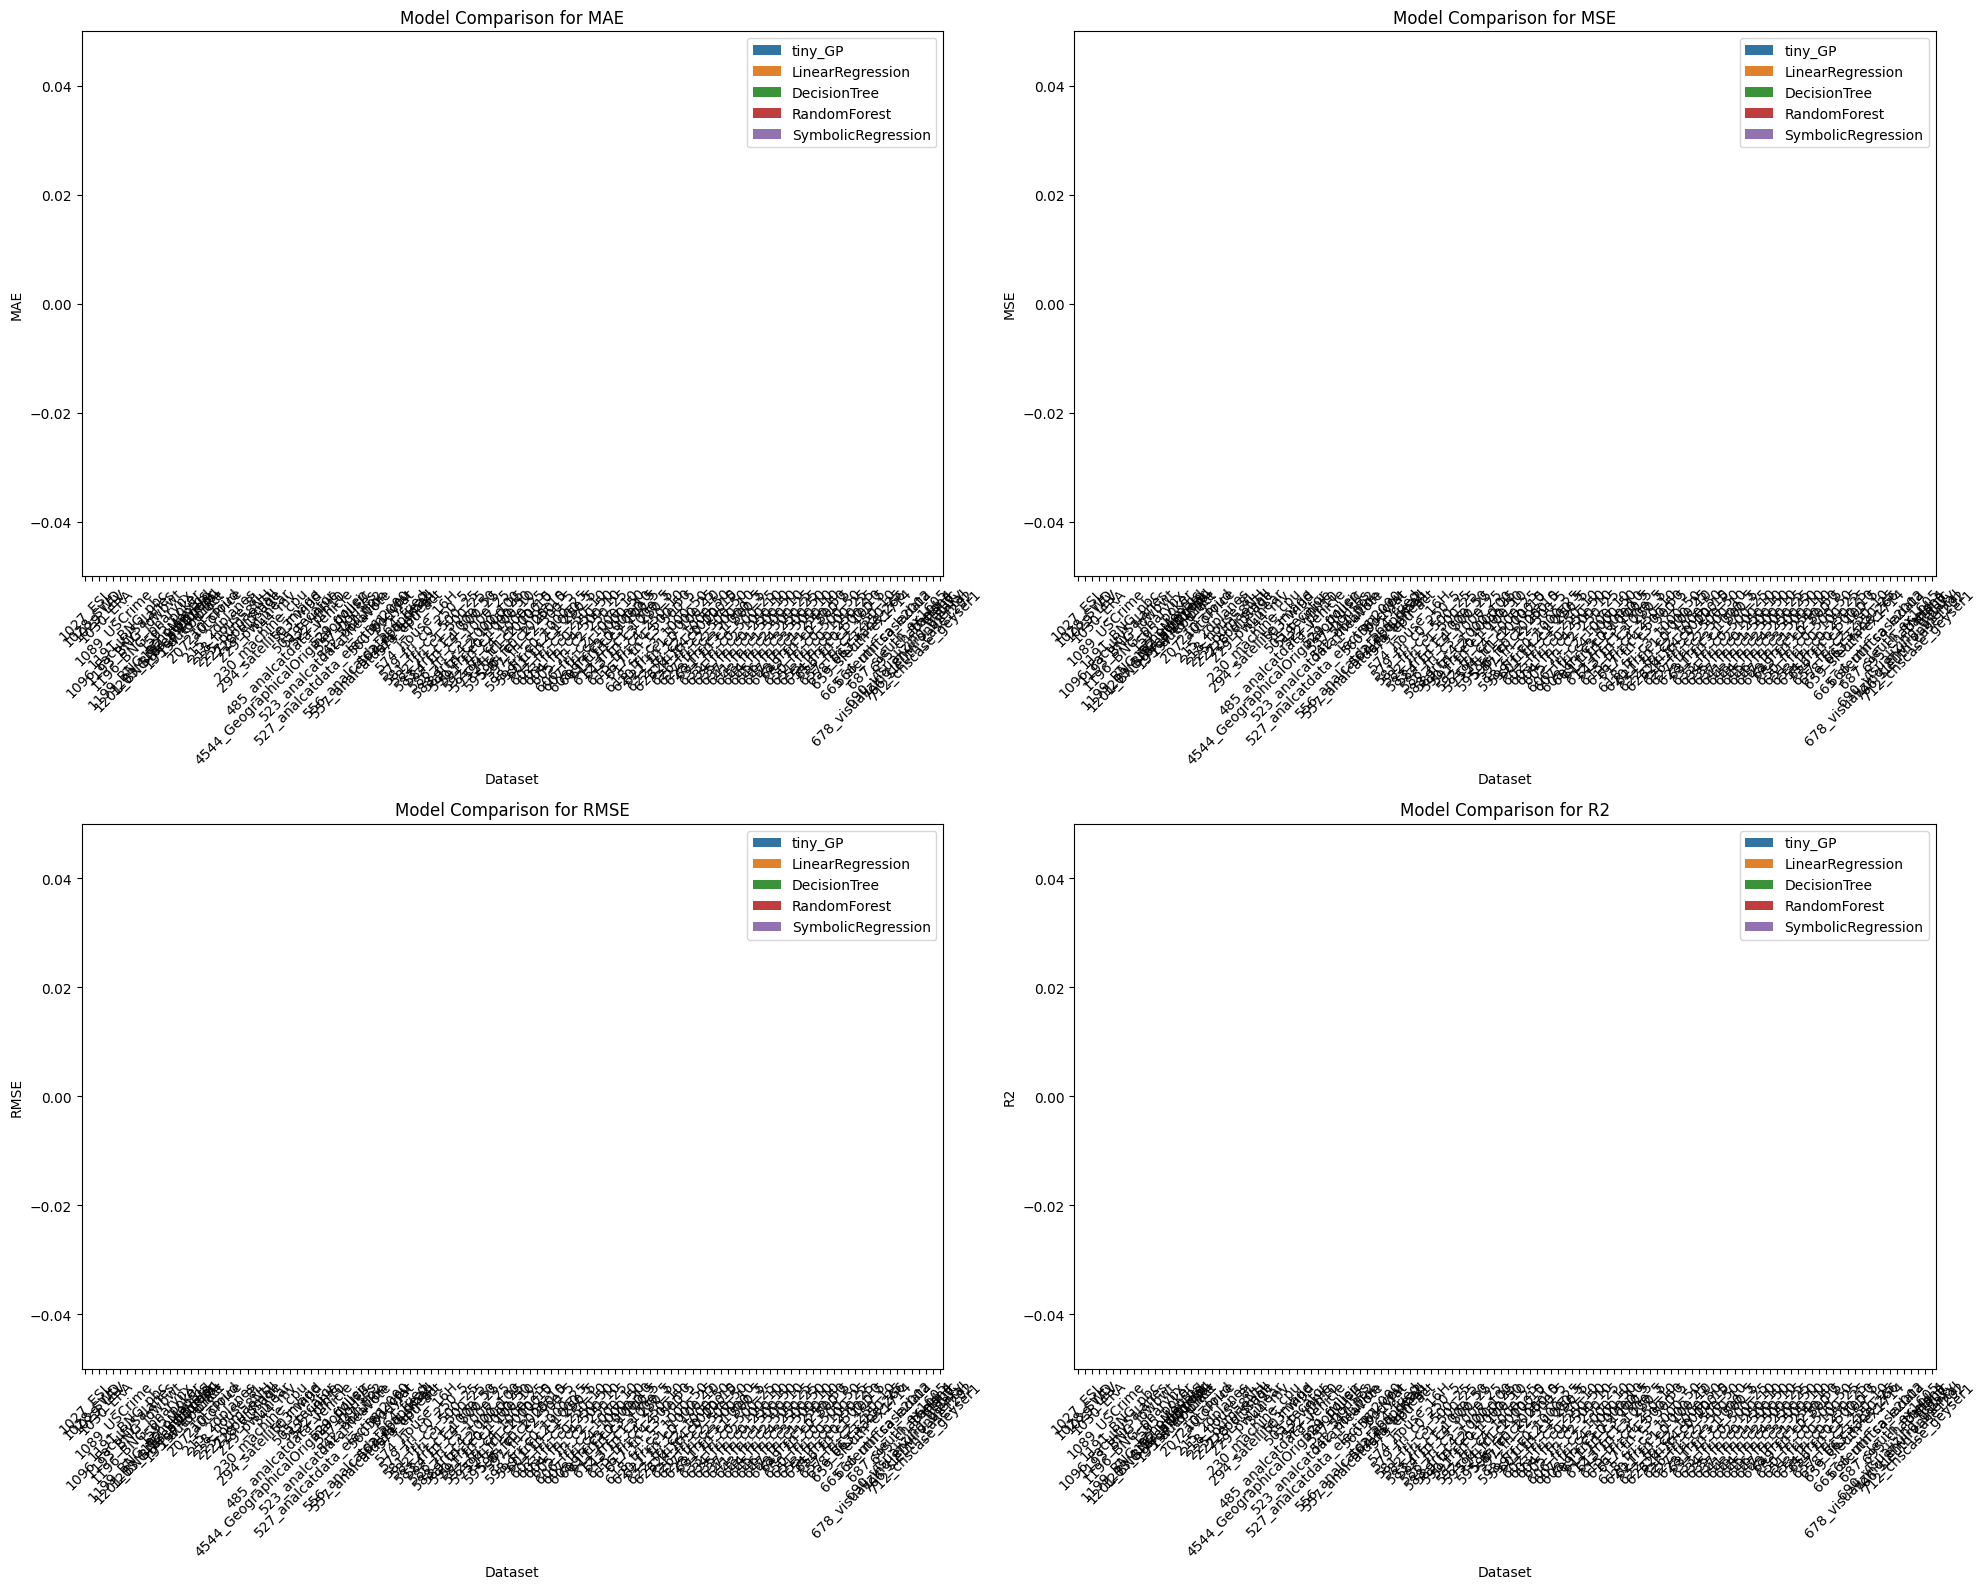

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터프레임 구조 가정
# results_df는 각 데이터셋에 대한 모델별 성능 지표가 포함되어 있어야 합니다.
# 예시: results_df 구조
# Dataset | tiny_GP (dict) | LinearRegression (dict) | DecisionTree (dict) | RandomForest (dict) | SymbolicRegression (dict)
# 'Dataset1' | {'MAE': 0.1, 'MSE': 0.2, 'RMSE': 0.14, 'R2': 0.9} | ...

metrics = ['MAE', 'MSE', 'RMSE', 'R2']
models = ['tiny_GP', 'LinearRegression', 'DecisionTree', 'RandomForest', 'SymbolicRegression']

# 전체 그림 크기 설정
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 16))  # 2x2 서브플롯
axes = axes.flatten()  # 1차원 배열로 변환

# 각 메트릭별로 서브플롯 생성
for idx, metric in enumerate(metrics):
    # 각 모델의 성능 지표를 DataFrame에 맞게 변환
    for model in models:
        results_df[model] = results_df[model].apply(lambda x: x.get(metric, float('nan')) if isinstance(x, dict) else float('nan'))

    # 모델별 성능 지표를 melt를 통해 긴 형식으로 변환
    melted_df = results_df.melt(id_vars=['Dataset'], value_vars=models, var_name='Model', value_name=metric)

    # 성능 비교를 위한 막대 그래프 생성
    sns.barplot(x='Dataset', y=metric, hue='Model', data=melted_df, ax=axes[idx])
    axes[idx].set_title(f'Model Comparison for {metric}')
    axes[idx].tick_params(axis='x', rotation=45)  # x축 레이블 회전
    axes[idx].legend(loc='upper right')  # 범례 위치 조정
    axes[idx].set_ylim([-0.05, 0.05])  # y축 범위 조정

plt.tight_layout()  # 겹치는 부분 방지
plt.show()

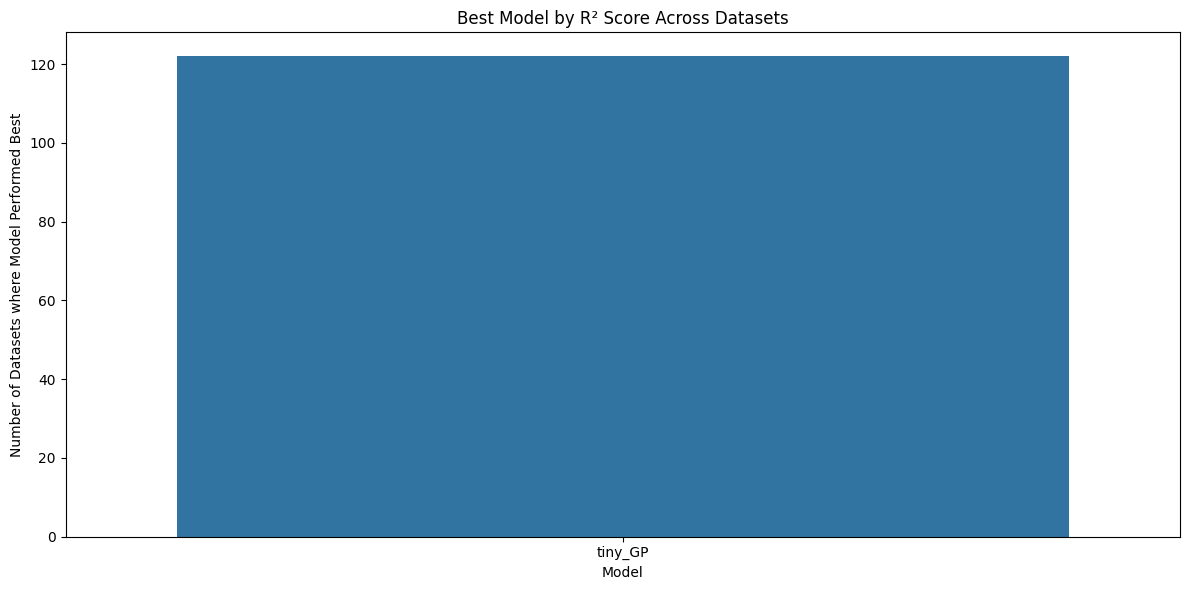

In [30]:
# 각 데이터셋에서 R² 스코어가 가장 높은 모델을 시각화
best_models_r2 = []

for index, row in results_df.iterrows():
    # 각 모델의 R² 값 추출, 값이 dict인지 확인 후 추출
    r2_values = []
    for model in models:
        # 모델 결과가 딕셔너리일 때 R2 값을 가져오고, 아니면 NaN 처리
        r2_value = row[model]['R2'] if isinstance(row[model], dict) else float('nan')
        r2_values.append(r2_value)

    # R² 값 중 가장 높은 모델 선택
    best_model = models[r2_values.index(max(r2_values))]
    best_models_r2.append(best_model)

# results_df에 최고 성능 모델 추가
results_df['Best_R2_Model'] = best_models_r2

# 최고 성능 모델에 대한 히스토그램 시각화
plt.figure(figsize=(12, 6))
sns.countplot(x='Best_R2_Model', data=results_df)
plt.title('Best Model by R² Score Across Datasets')
plt.xlabel('Model')
plt.ylabel('Number of Datasets where Model Performed Best')
plt.tight_layout()
plt.show()